# 558 Homework 3 - Exercise 2
#### Anushna Prakash
#### April 23, 2021

$$\begin{equation}
F(\beta) = \frac{1}{n} \sum_{i=1}^n log(1 + e^{-y_i x_i^T \beta}) + \lambda ||\beta||_2^2
\end{equation}
$$

Assume the case where $n=1$ and $d=1$. Then:
$$
F(\beta) = log(1 + e^{-y_{i} x_{i}^T \beta}) + \lambda \beta^2
\\ \nabla F(\beta) = \frac{-yx e^{-yx\beta}}{1 + e^{-yx \beta}} + 2\lambda \beta
$$

Now assuming the case where $n>1$ and $d>1$, and $y$ is $1xn$, $x$ is $dxn$ and $\beta$ is $dx1$:
$$
\nabla F(\beta) = \frac{1}{n} \frac{-y^T x e^{-y x^T \beta}}{1 + e^{-y x^T \beta}} + 2 \lambda \beta 
$$

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [2]:
file = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Smarket.csv'
smarket = pd.read_csv(file, sep = ',', header = 0, index_col = 0)
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [3]:
X = smarket[['Lag1', 'Lag2', 'Volume']].to_numpy()
# y = {1, -1} for {Up, Down}
y = smarket['Direction'].apply(lambda x: 1 if (x == 'Up') else -1).to_numpy()
print(X.shape)
print(y.shape)
X_train_us, X_test_us, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

(1250, 3)
(1250,)


In [4]:
# Standardize train and test sets on training data
X_ss = StandardScaler().fit(X_train_us)
X_train = X_ss.transform(X_train_us)
X_test = X_ss.transform(X_test_us)

In [5]:
def computegrad(beta, X, y, lambda_):
    """
    Returns the gradient for regularized logistic regression.
    
    Parameters
    ----------
    beta : 1D array
        A numpy array with shape 1 x d
    X : ndarray
        A numpy array of standardized feature variables with shape n x d
    y : 1D array
        A numpy array of standardized response variables with shape 1 x n
    lambda_ : float
        Regularization parameter
    
    Returns
    -------
    grad : 1D array
        A numpy array of the gradient with the given X, y, and lambda with shape 1 x d
    """
    n = X.shape[0]
    e_ = np.exp(np.multiply(-y, X @ beta))
    Q = np.diag(e_ / (e_ + 1))
    return (-1/n) * (X.T @ Q @ y)  + 2 * lambda_ * beta

In [6]:
def computeobj(beta, X, y, lambda_):
    """
    Returns the gradient for regularized logistic regression.
    
    Parameters
    ----------
    beta : 1D array
        A numpy array with shape 1 x d
    X : ndarray
        A numpy array of standardized feature variables with shape n x d
    y : 1D array
        A numpy array of standardized response variables with shape 1 x n
    lambda_ : float
        Regularization parameter
    
    Returns
    -------
    obj : float
        Value of the objective function evaluated with the given parameters
    """
    n = X.shape[0]
    e_ = np.exp(np.multiply(-y, X @ beta))
    return (1/n) * np.sum(np.log(1 + e_)) + lambda_ * np.linalg.norm(beta)**2

In [7]:
def backtracking(eta_init, decay_rate, prop, p, beta, *args):
    """
    Returns the optimal eta for fast gradient descent.
    
    Parameters
    ----------
    eta_init : float
    decay_rate : float
        The rate at which eta will decay for search
    prop : float
        Constant for proportionality between descent and directional derivative
    p : 1D array
        A numpy array with shape 1 x d representing the direction
    beta : 1D array
        A numpy array with shape 1 x d
    *args : X, y, lambda_
    
    Returns
    -------
    eta : float
        Optimal size of eta for fast gradient descent
    """
    eta = eta_init
    
    def decrease_condition(eta):
        """
        Compute if the difference in objective functions evaluated with new vs. old beta
        is less than eta*prop* Beta p
        """
        left = computeobj(beta + eta * p, *args) - computeobj(beta, *args)
        right = eta * prop * np.dot(computegrad(beta, *args), p)
        return left <= right
    
    while not decrease_condition(eta):
        eta *= decay_rate
    
    return eta

In [8]:
def graddescent(tolerance, eta_init, decay_rate, prop, beta_init, *args):
    """
    Returns the optimal eta for fast gradient descent.
    
    Parameters
    ----------
    tolerance: float
        A total error tolerance
    eta_init : float
    decay_rate : float
        The rate at which eta will decay for search
    prop : float
        Constant for proportionality between descent and directional derivative
    beta_init : 1D array
        A numpy array with shape 1 x d
    *args : X, y, lambda_
    
    Returns
    -------
    iterations : list
        List of betas with most optimal beta being at [-1] index
    """
    iterations = [beta_init]
    grad = computegrad(beta_init, *args)
    beta = beta_init
    
    while np.linalg.norm(grad) > tolerance:
        p = -grad
        eta = backtracking(eta_init, decay_rate, prop, p, beta, *args)
        beta = beta - eta * computegrad(beta, *args)
        grad = computegrad(beta, *args)
        iterations.append(beta)
    
    return iterations

In [9]:
def fastgradalgo(tolerance, eta_init, decay_rate, prop, X, y, lambda_):
    """
    Returns the optimal eta for fast gradient descent.
    
    Parameters
    ----------
    tolerance: float
        A total error tolerance
    eta_init : float
    decay_rate : float
        The rate at which eta will decay for search
    prop : float
        Constant for proportionality between descent and directional derivative
    num_features : int
        Number of features in data set
    *args : X, y, lambda_
    
    Returns
    -------
    iterations : list
        List of betas with most optimal beta being at [-1] index
    """
    beta = np.zeros(X.shape[1])
    theta = np.zeros(X.shape[1])
    iterations = [beta]
    grad = computegrad(beta, X, y, lambda_)
    t = 0
    
    while np.linalg.norm(grad) > tolerance:
        p = -grad
        eta = backtracking(eta_init, decay_rate, prop, p, beta, X, y, lambda_)
        beta_t = theta - eta * computegrad(theta, X, y, lambda_)
        theta = beta_t + (t / (t + 3)) * (beta_t - beta)
        grad = computegrad(beta_t, X, y, lambda_)
        beta = beta_t
        t += 1
        iterations.append(beta)
    
    return iterations

##### Exercise 2-(i). Initialize parameters such that:
$\\ \eta = 0.1$
$\\ \epsilon = 0.00001$
$\\ \lambda = 0.5$

In [10]:
import matplotlib.pyplot as plt

In [11]:
# Initialize parameters
eta_init = 0.1
error = 1e-5
lambda_ = 0.5
decay_rate = 0.3 # Must be between [0, 1]
prop = 0.8 # Must be between [0, 1]
beta_init = np.zeros(X.shape[1])

grad_descent = graddescent(error, eta_init, decay_rate, prop, beta_init, X_train, y_train, lambda_)
f_slow = [computeobj(b, X_train, y_train, lambda_) for b in grad_descent]
fast_grad_descent = fastgradalgo(error, eta_init, decay_rate, prop, X_train, y_train, lambda_)
f_fast = [computeobj(b, X_train, y_train, lambda_) for b in fast_grad_descent]

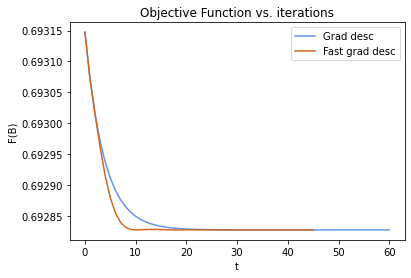

In [12]:
plt.plot(f_slow, c = 'cornflowerblue')
plt.plot(f_fast, c = 'chocolate')
plt.title('Objective Function vs. iterations')
plt.xlabel('t')
plt.ylabel('F(B)')
plt.legend(['Grad desc', 'Fast grad desc'])

The graph shows that the fast gradient descent algorithm does not necessary monotonically decrase. It earns its name as the algorithm converges in roughly two-thirds as many iterations as the traditional gradient descent.

##### Exercise 2-(j)

`sklearn`'s Regularized Logistic Regression minimizes the function
$$ \begin{equation}
F(\beta) = \frac{1}{2} \beta^{T} \beta + C \sum_{i = 1}^{n} log(-y_{i}(X_{i}^T \beta + c)+1)
\end{equation}$$

The $C$ hyperparameter corresponds with $\lambda = \frac{1}{2nC}$, or $C = \frac{1}{2n\lambda}$

In [13]:
lambda_ = 0.5
n = X_train.shape[0]
c = 1 / (lambda_ * n * 2)
b_t = fast_grad_descent[-1]
sk_logistic = LogisticRegression(penalty = 'l2',
                                 tol = error,
                                 C = c,
                                 fit_intercept = False).fit(X_train, y_train)
b_star = sk_logistic.coef_.ravel()

In [14]:
print('Beta_T - Beta*: ', (b_t - b_star))
f_t = computeobj(b_t, X_train, y_train, lambda_)
f_star = computeobj(b_star, X_train, y_train, lambda_)
print("F(B_T): ", f_t)
print("F(B*): ", f_star)

Beta_T - Beta*:  [ 2.09485020e-06  1.48732440e-07 -1.56075096e-07]
F(B_T):  0.6928272154193231
F(B*):  0.6928272154165531


`sklearn`'s implementation produced a similar $\beta$s compared to my implementation of fast gradient descent within $\pm 0.25$ for each $\beta_d$.
The objective functions are both similarly minimized, within $\pm 0.005$, so the solutions are basically equivalent.

##### Exercise 2-(k) - Cross Validation to find $\lambda$ or $C$

In [15]:
log_cv = LogisticRegressionCV(penalty = 'l2').fit(X_train, y_train).C_
opt_lambda = 1 / (2 * n * log_cv[0])
log_cv[0]

0.046415888336127774

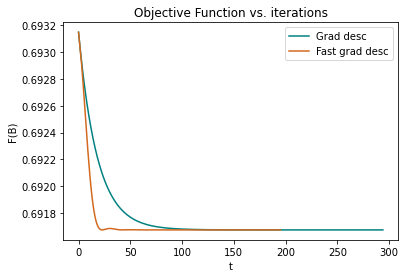

In [16]:
# Initialize parameters
eta_init = 0.1
error = 1e-5
beta_init = np.zeros(X.shape[1])

grad_descent = graddescent(error, eta_init, decay_rate, prop, beta_init, X_train, y_train, opt_lambda)
f_slow = [computeobj(b, X_train, y_train, opt_lambda) for b in grad_descent]
fast_grad_descent = fastgradalgo(error, eta_init, decay_rate, prop, X_train, y_train, opt_lambda)
f_fast = [computeobj(b, X_train, y_train, opt_lambda) for b in fast_grad_descent]

plt.plot(f_slow, c = 'teal')
plt.plot(f_fast, c = 'chocolate')
plt.title('Objective Function vs. iterations')
plt.xlabel('t')
plt.ylabel('F(B)')
plt.legend(['Grad desc', 'Fast grad desc'])

The plot once again shows that fast gradient descent algorithm is not monotonically converging, but does converge in roughly 2/3 the number of iterations as the simpler gradient descent.

In [17]:
def misclass_rate(beta, X, y):
    """
    Returns the misclassification rate with the given beta and X versus the
    response data, y.
    
    Parameters
    ----------
    beta : 1D array
        A 1xd numpy array
    X : ndarray
        A n x d numpy array of feature data
    y : 1D array
        A 1 x n numpy array of correct response data
    
    Returns
    -------
    misclass : float
        Misclassification rate
    """
    prob = np.exp(np.dot(X, beta)) / (np.exp(np.dot(X, beta)) + 1)
    prediction = np.zeros(len(prob))

    for i in range(len(prob)):
        if prob[i] >= 0.5:
            prediction[i] = 1
        else:
            prediction[i] = -1
    
    return np.mean(prediction != y)

In [18]:
misclass_slow = [misclass_rate(b, X_train, y_train) for b in grad_descent]
misclass_fast = [misclass_rate(b, X_train, y_train) for b in fast_grad_descent]

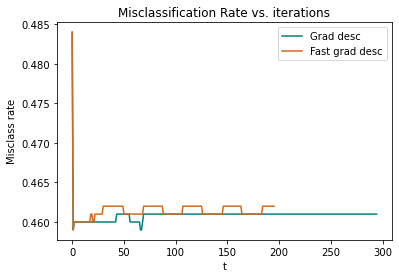

In [19]:
plt.plot(misclass_slow, c = 'teal')
plt.plot(misclass_fast, c = 'chocolate')
plt.title('Misclassification Rate vs. iterations')
plt.xlabel('t')
plt.ylabel('Misclass rate')
plt.legend(['Grad desc', 'Fast grad desc'])

The fast gradient descent algorithm has a bit more variability in the misclassification rate, but stabilizes to the same rate as the normal gradient descent, with a misclassification rate ~ 46.3%. Unfortunately, this means that both algorithms produce a classifier that performs only slightly better than a coin flip on the training data.

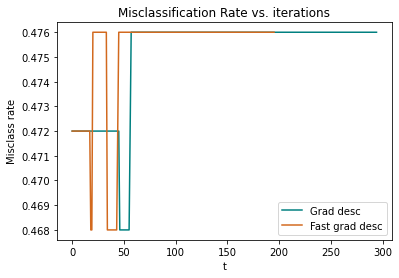

In [20]:
misclass_slow = [misclass_rate(b, X_test, y_test) for b in grad_descent]
misclass_fast = [misclass_rate(b, X_test, y_test) for b in fast_grad_descent]

plt.plot(misclass_slow, c = 'teal')
plt.plot(misclass_fast, c = 'chocolate')
plt.title('Misclassification Rate vs. iterations')
plt.xlabel('t')
plt.ylabel('Misclass rate')
plt.legend(['Grad desc', 'Fast grad desc'])

On the test set, we see similar misclassification rates that stabilize at around the same percentage of 47.6%. Again, only slightly better than a coin flip.